In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose



In [2]:
path = ''
image_path = os.path.join(path, './data/x-rgb/')
mask_path = os.path.join(path, './data/y-mask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
print(len(image_list), len(mask_list))

1060 1060


C:\Users\khale\AppData\Local\Temp\ipykernel_23776\2436831778.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\khale\AppData\Local\Temp\ipykernel_23776\2436831778.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

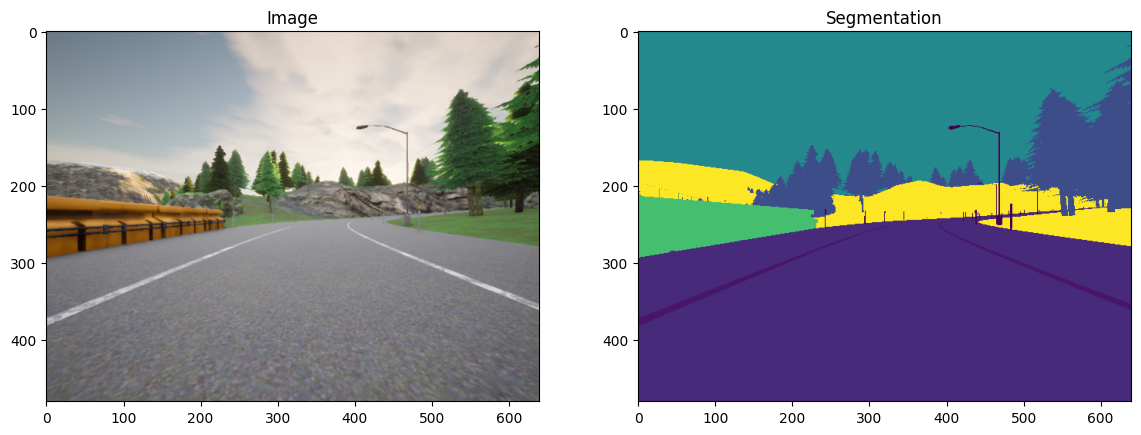

In [3]:
N = 18
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0]) # Displaying only one channel of the mask
arr[1].set_title('Segmentation')

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False) # converts the lists into TensorFlow Datasets where each element is a file path.
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\x-rgb\\000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\y-mask\\000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\x-rgb\\000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\y-mask\\000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\x-rgb\\000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\y-mask\\000028.png'>)


In [5]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

 # Converts Python lists into TensorFlow string tensors then creates a dataset where each element is a tuple of (image_path, mask_path)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)



tf.Tensor(b'./data/x-rgb/000026.png', shape=(), dtype=string)


In [6]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3) # converts bytes into 3D tensors
    img = tf.image.convert_image_dtype(img, tf.float32) # scales pixel values to [0, 1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3) # collapses 3 channels of mask into single channel
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [7]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [8]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,# Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    return conv

In [9]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """

    input = Input(input_size)

    cblock1 = conv_block(input, n_filters * 1)

    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False)


    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters * 1)
    
    conv9 = Conv2D(n_filters, # Number of filters
                   3, # Kernel size 
                     activation='relu',
                     padding = 'same',
                     kernel_initializer = 'he_normal')(ublock9)
    conv10 = Conv2D(n_classes, # Number of filters
                    1, # Kernel size
                    padding='same',)(conv9)
    model = tf.keras.Model(inputs=input, outputs=conv10)
    return model

In [10]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [11]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 128,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 128,   │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 128,   │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 24, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 8, 256) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 6, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 6, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 6, 8, 512) │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 12, 16,    │  1,179,904 │ dropout_1[0][0] 

 Total params: 8,640,471 (32.96 MB)

 Trainable params: 8,640,471 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
unet.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


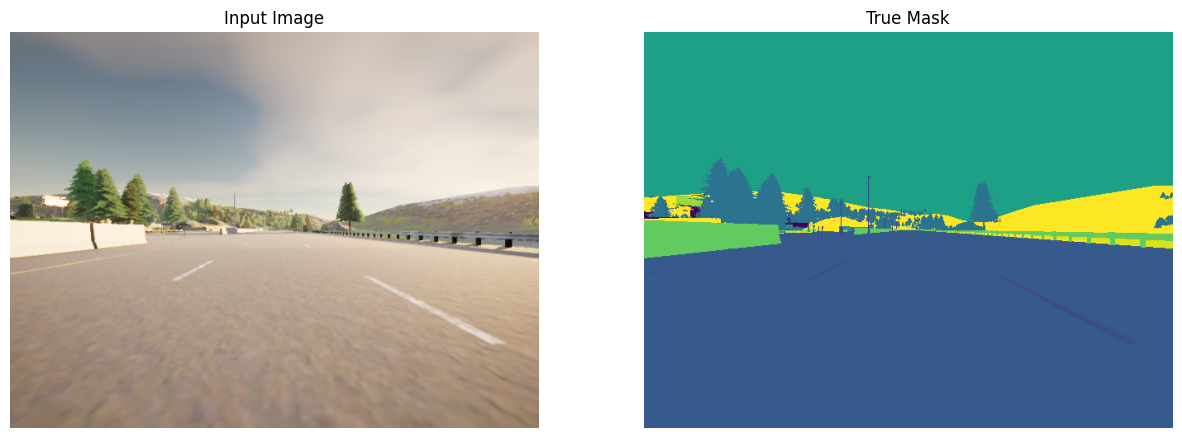

In [14]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])


(96, 128, 1)


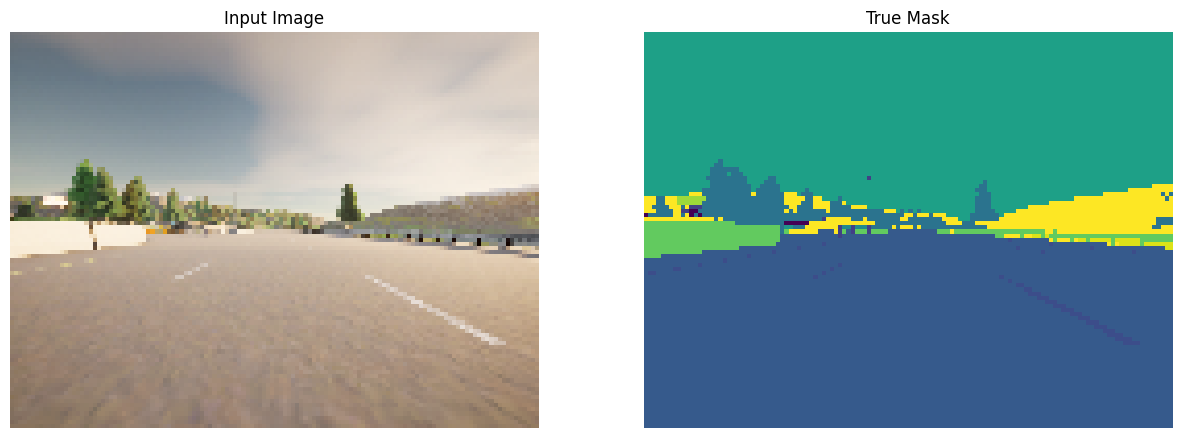

(96, 128, 1)
(96, 128, 3)


In [15]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])
print(sample_mask.shape)
print(sample_image.shape)

In [16]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.2843 - loss: 3.8656
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4930 - loss: 1.7736
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7579 - loss: 0.9456
Epoch 4/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7792 - loss: 0.7531
Epoch 5/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7935 - loss: 0.7340
Epoch 6/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8013 - loss: 0.6467
Epoch 7/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8039 - loss: 0.6215
Epoch 8/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8089 - loss: 0.5837
Epoch 9/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8013 - loss: 0.6309
Epoch 10/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8053 - loss: 0.5673
Epoch 11/40
34/34 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis] # Add a new axis at the end 
    return pred_mask[0] # Return the first mask in the batch

Text(0, 0.5, 'Accuracy')

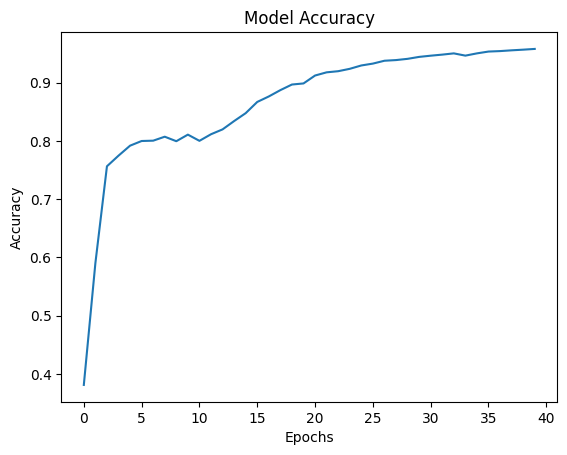

In [19]:
plt.plot(model_history.history["accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


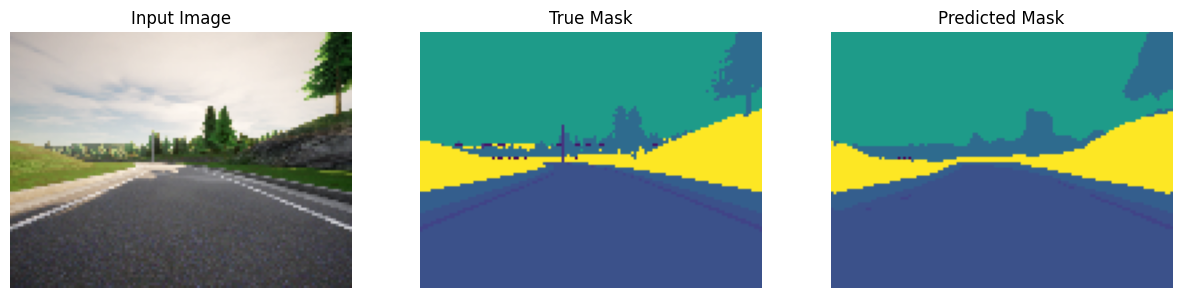

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


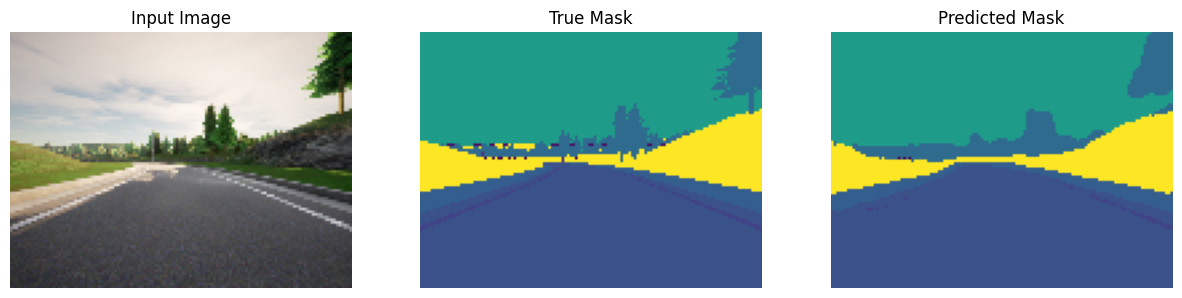

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


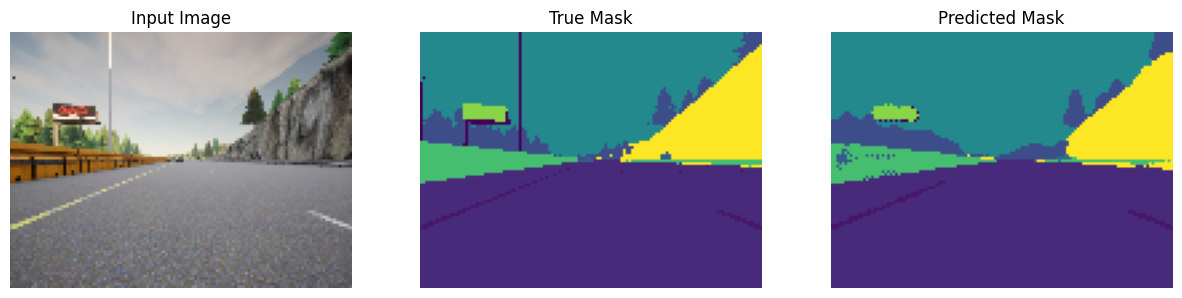

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


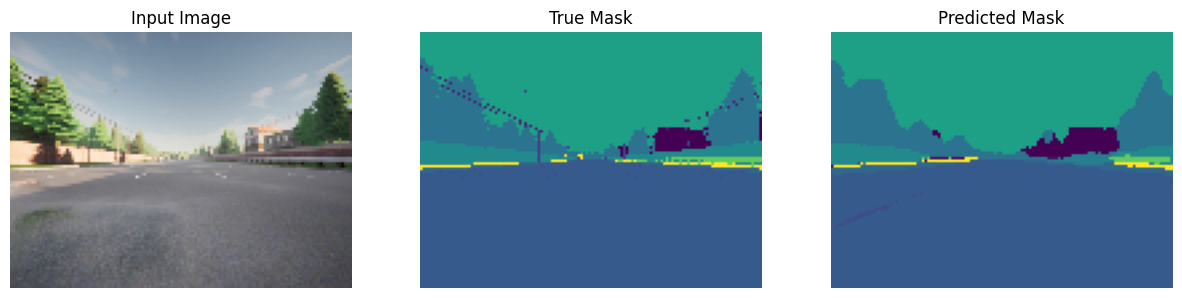

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


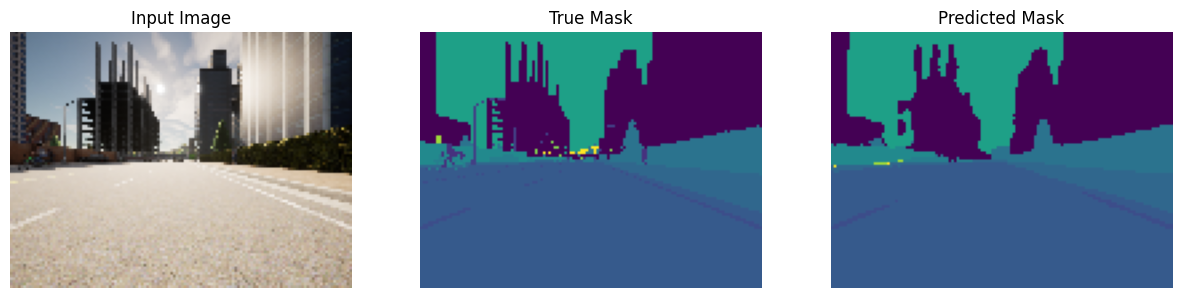

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


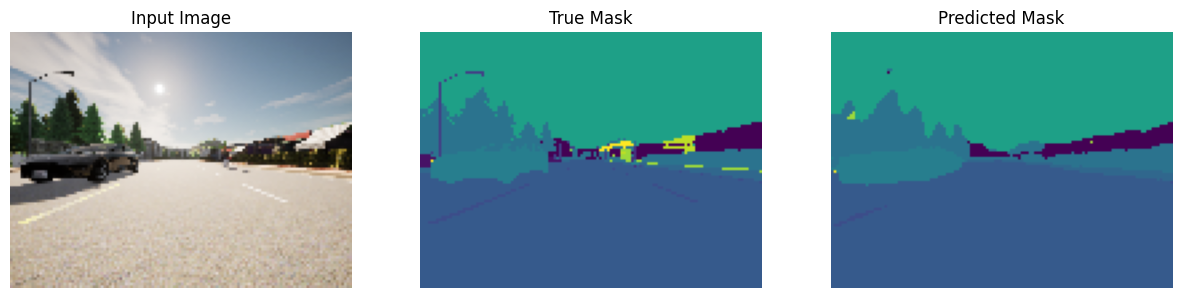

In [20]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])
show_predictions(train_dataset, 6)